# MITRE ATT&CK Group Technique Analysis

#Commands used to pull data 

import mitreattack.attackToExcel.attackToExcel as attackToExcel 
import mitreattack.attackToExcel.stixToDf as stixToDf

attackToExcel.export("enterprise-attack", "v9.0", "C://Users//cindy//Desktop//MITRE_Data_project")


In [1]:
#Import Packages and Set-Up
import pandas as pd
import matplotlib as mpl 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from wordcloud import WordCloud, STOPWORDS
from pandas.plotting import parallel_coordinates
import datetime as dt
import random



%matplotlib inline

import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True) 

In [2]:
#Set today's Date to use later
date = pd.to_datetime(dt.date.today())

#Set path where files are located
path = 'C:\\Users\\cindy\\Desktop\\MITRE_Data_project\\'

# Retreive raw data files from downloads

In [3]:
#Define functions for later use

def convert_timestamp(my_col):
    my_col = pd.to_datetime(my_col)
    return my_col

def replace_commas(df):
    for i in df.columns:
        try:
            df[i].astype('str')
            df[i] = df[i].apply(lambda x: x.strip())
            df[i] = df[i].apply(lambda x: x.replace(",", ""))
        except:
            pass
    return df

def replace_bools(df):
    my_cols = df.columns
    for i in my_cols:
        if type(i) == 'bool':
            df[i] = df[i].astype('int')
    return df
  
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    '''Makes wordcloud grayscale colors'''
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

def random_redcolor_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    '''Creates a text wordcloud in various red hues.'''
    
    h = int(360.0 * 3.0 / 255.0)
    s = int(100.0 * float(random_state.randint(120, 255))  / 255.0)
    l = int(100.0 * float(random_state.randint(85, 220)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

def find_rare(mystr, mylist): 
    if mystr in mylist:
        return 1
    else:
        return 0
        
def find_common(mystr, mylist):
    if mystr in mylist:
        return 1
    else:
        return 0
    

def calculate_last_active(last_seen):
    date = pd.to_datetime(dt.date.today())
    last_seen= date - last_seen
    last_seen = last_seen.astype('str')
    last_seen = last_seen.apply(lambda x : x.replace(' days', ''))
    last_seen = last_seen.astype('int') * -1
    return last_seen

def find_tactics(df):
    df['tactics'] = df['tactics'].apply(lambda x: x.replace(", " , ','))
    df2 = df['tactics'].str.split(",", expand = True)
    df2 = df2.apply(lambda x : x.replace(' ', '_'))
    df2 = df2.stack()
    tactics_list = df2.to_list()
    tactics_list = set(tactics_list)
    print(tactics_list)
    
    for i in tactics_list:
        df[i] = df['tactics'].str.contains(i).astype('int')
    df['Total_Tactics'] = df[tactics_list].sum(axis=1)
    return df   

def parse_platforms(df):
    df['platforms'] = df['platforms'].apply(lambda x: x.replace(", " , ','))
    df2 = df['platforms'].str.split(",", expand = True)
    df2 = df2.apply(lambda x : x.replace(' ', '_'))
    df2 = df2.stack()
    platforms_list = df2.to_list()
    platforms_list = set(platforms_list)
    print(platforms_list)
    
    for i in platforms_list:
        df[i] = df['platforms'].str.contains(i).astype('int')
    df['Total_Platforms'] = df[platforms_list].sum(axis=1)
    return df   


#Parse Permissions

def parse_permissions(df):
    df['Permissions_Required'].fillna(value='Unknown', inplace=True)
    df['Permissions_Required'] = df['Permissions_Required'].apply(lambda x: x.replace(", " , ','))
    df2 = df['Permissions_Required'].str.split(",", expand = True)
    df2 = df2.apply(lambda x : x.replace(' ', '_'))
    df2 = df2.stack()
    permissions_list = df2.to_list()
    permissions_list = set(permissions_list)
    print(permissions_list)
    for i in permissions_list:
        df[i] = df['Permissions_Required'].str.contains(i).astype('int')
    df['Total_Permissions'] = df[permissions_list].sum(axis=1)
    return df   


def parse_bypassed_defenses(df):
    df['Defenses_Bypassed'].fillna(value='Unknown', inplace=True)
    df['Defenses_Bypassed'] = df['Defenses_Bypassed'].apply(lambda x: x.replace(", " , ','))
    df['Defenses_Bypassed'] = df['Defenses_Bypassed'].apply(lambda x: x.replace('-', ' '))
    df['Defenses_Bypassed'] = df['Defenses_Bypassed'].apply(lambda x: x.title())
    df2 = df['Defenses_Bypassed'].str.split(",", expand = True)
    df2 = df2.stack()
    
    defense_bypass_list = df2.to_list()
    defense_bypass_list = set(defense_bypass_list)
    print(defense_bypass_list)
    for i in defense_bypass_list:
        df[i] = df['Defenses_Bypassed'].str.contains(i).astype('int')
    df['Total_Bypassed'] = df[defense_bypass_list].sum(axis=1)
    return df   

def parse_data_sources(df):
    df['data sources'] = df['data sources'].astype('str')
    df['data sources'] = df['data sources'].apply(lambda x: x.replace(", " , ','))
    df2 = df['data sources'].str.split(",", expand = True)
    df2 = df2.apply(lambda x : x.replace(' ', '_'))
    df2 = df2.stack()
    datasource_list = df2.to_list()
    datasource_list = set(datasource_list)
    print(datasource_list)
    
    for i in datasource_list:
        df[i] = df['data sources'].str.contains(i).astype('int')
    df['Total_Data_Sources'] = df[datasource_list].sum(axis=1)
    return df 


def find_recent_techniques(df):
    date = pd.to_datetime(dt.date.today())
    df['Technique_Updated'] = date - df['Technique_Last_Modified']
    df['Technique_Updated'] = df['Technique_Updated'].astype('str')
    df['Technique_Updated'] = df['Technique_Updated'].apply(lambda x : x.replace(' days', ''))
    df['Technique_Updated'] = df['Technique_Updated'].astype('int')
    return df





# Add Supplemental Details about Techniques Used

In [4]:
techniques = pd.read_excel(path + 'enterprise-attack-v9.0.xlsx',sheet_name='techniques', header=0, index_col=None)
techniques.rename(columns = {'ID': 'Technique_ID', 'name' : 'Technique_Name', 'description' : 'Technique_Description', 'created' : 'Technique_Created', 'last modified': 'Technique_Last_Modified', 'supports remote': 'Supports_Remote', 'defenses bypassed': 'Defenses_Bypassed', 'permissions required':'Permissions_Required', 'sub-technique of':'Parent_Technique', 'detection': 'Technique_detection', 'is sub-technique':'Sub_Technique'}, inplace=True)
techniques['Technique_Created'] = convert_timestamp(techniques['Technique_Created'])
techniques['Technique_Last_Modified'] = convert_timestamp(techniques['Technique_Last_Modified'])
techniques            

,Technique_ID,Technique_Name,Technique_Description,url,Technique_Created,Technique_Last_Modified,version,tactics,Technique_detection,platforms,data sources,Sub_Technique,Parent_Technique,contributors,Permissions_Required,Defenses_Bypassed,Supports_Remote
0,T1548,Abuse Elevation Control Mechanism,Adversaries may circumvent mechanisms designed...,https://attack.mitre.org/techniques/T1548,2020-01-30,2020-07-22,1.0,"Defense Evasion, Privilege Escalation",Monitor the file system for files that have th...,"Linux, Windows, macOS","Command: Command Execution, File: File Metadat...",False,NaN,NaN,"Administrator, User",NaN,NaN
1,T1548.002,Abuse Elevation Control Mechanism: Bypass User...,Adversaries may bypass UAC mechanisms to eleva...,https://attack.mitre.org/techniques/T1548/002,2020-01-30,2020-07-22,2.0,"Defense Evasion, Privilege Escalation",There are many ways to perform UAC bypasses wh...,Windows,"Command: Command Execution, Process: Process C...",True,T1548,Casey Smith; Stefan Kanthak,"Administrator, User",Windows User Account Control,NaN
2,T1548.004,Abuse Elevation Control Mechanism: Elevated Ex...,Adversaries may leverage the <code>Authorizati...,https://attack.mitre.org/techniques/T1548/004,2020-01-30,2020-03-27,1.0,"Defense Evasion, Privilege Escalation",Consider monitoring for <code>/usr/libexec/sec...,macOS,"Process: OS API Execution, Process: Process Cr...",True,T1548,"Erika Noerenberg, @gutterchurl, Carbon Black; ...","Administrator, User",NaN,NaN
3,T1548.001,Abuse Elevation Control Mechanism: Setuid and ...,An adversary may perform shell escapes or expl...,https://attack.mitre.org/techniques/T1548/001,2020-01-30,2020-03-27,1.0,"Defense Evasion, Privilege Escalation",Monitor the file system for files that have th...,"Linux, macOS","Command: Command Execution, File: File Metadat...",True,T1548,NaN,User,NaN,NaN
4,T1548.003,Abuse Elevation Control Mechanism: Sudo and Su...,Adversaries may perform sudo caching and/or us...,https://attack.mitre.org/techniques/T1548/003,2020-01-30,2020-03-27,1.0,"Defense Evasion, Privilege Escalation","On Linux, auditd can alert every time a user's...","Linux, macOS","Command: Command Execution, File: File Modific...",True,T1548,NaN,User,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,T1102.002,Web Service: Bidirectional Communication,"Adversaries may use an existing, legitimate ex...",https://attack.mitre.org/techniques/T1102/002,2020-03-14,2020-03-26,1.0,Command And Control,Host data that can relate unknown or suspiciou...,"Linux, Windows, macOS","Network Traffic: Network Connection Creation, ...",True,T1102,NaN,NaN,NaN,NaN
548,T1102.001,Web Service: Dead Drop Resolver,"Adversaries may use an existing, legitimate ex...",https://attack.mitre.org/techniques/T1102/001,2020-03-14,2020-03-26,1.0,Command And Control,Host data that can relate unknown or suspiciou...,"Linux, Windows, macOS","Network Traffic: Network Traffic Content, Netw...",True,T1102,NaN,NaN,NaN,NaN
549,T1102.003,Web Service: One-Way Communication,"Adversaries may use an existing, legitimate ex...",https://attack.mitre.org/techniques/T1102/003,2020-03-14,2020-03-26,1.0,Command And Control,Host data that can relate unknown or suspiciou...,"Linux, Windows, macOS","Network Traffic: Network Connection Creation, ...",True,T1102,NaN,NaN,NaN,NaN
550,T1047,Windows Management Instrumentation,Adversaries may abuse Windows Management Instr...,https://attack.mitre.org/techniques/T1047,2017-05-31,2020-05-13,1.1,Execution,Monitor network traffic for WMI connections; t...,Windows,"Command: Command Execution, Network Traffic: N...",False,NaN,NaN,NaN,NaN,1.0


count     552.000000
mean      597.942029
std       395.048896
min        50.000000
25%       450.000000
50%       487.000000
75%       557.000000
max      1473.000000
Name: Technique_Age, dtype: float64


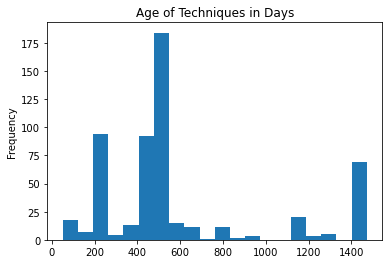

In [5]:
#Calculate the age of the technique
techniques['Technique_Age'] =  ( pd.to_datetime(dt.date.today()) - techniques['Technique_Created'] ).dt.days
print(techniques['Technique_Age'].describe())
techniques['Technique_Age'].plot(kind = 'hist', bins = 20, title = 'Age of Techniques in Days');

In [6]:
#Expand all techniques expressed as categories into dummy variables
before_expansion = techniques.shape
print(before_expansion[1])
techniques = find_tactics(techniques)
#Prints new tactics columns
techniques = parse_platforms(techniques)
#Prints new operating systems columns
techniques = parse_permissions(techniques)
#Prints new permissions columns
techniques = parse_bypassed_defenses(techniques)
#Prints new bypassed defenses columns
after_expansion = techniques.shape
print(after_expansion[1])


18
{'Execution', 'Privilege Escalation', 'Resource Development', 'Impact', 'Discovery', 'Persistence', 'Defense Evasion', 'Reconnaissance', 'Credential Access', 'Lateral Movement', 'Command And Control', 'Exfiltration', 'Collection', 'Initial Access'}
{'PRE', 'Google Workspace', 'Containers', 'Linux', 'IaaS', 'Office 365', 'SaaS', 'macOS', 'Windows', 'Azure AD', 'Network'}
{'Unknown', 'root', 'Administrator', 'SYSTEM', 'User'}
{'System Access Controls', 'Unknown', 'Signature Based Detection', 'Application Control', 'Application Control By File Name Or Path', 'Digital Certificate Validation', 'Autoruns Analysis', 'Process Whitelisting', 'Firewall', 'File Monitoring', 'Windows User Account Control', 'Encryption', 'Heuristic Detection', 'User Mode Signature Validation', 'Static File Analysis', 'Defensive Network Service Scanning', 'Binary Analysis', 'File System Access Controls', 'Host Forensic Analysis', 'Host Intrusion Prevention Systems', 'Network Intrusion Detection System', 'Router A

In [7]:
techniques.Total_Bypassed.value_counts()

1    480
2     37
3     18
4      9
5      3
6      2
7      2
8      1
Name: Total_Bypassed, dtype: int64

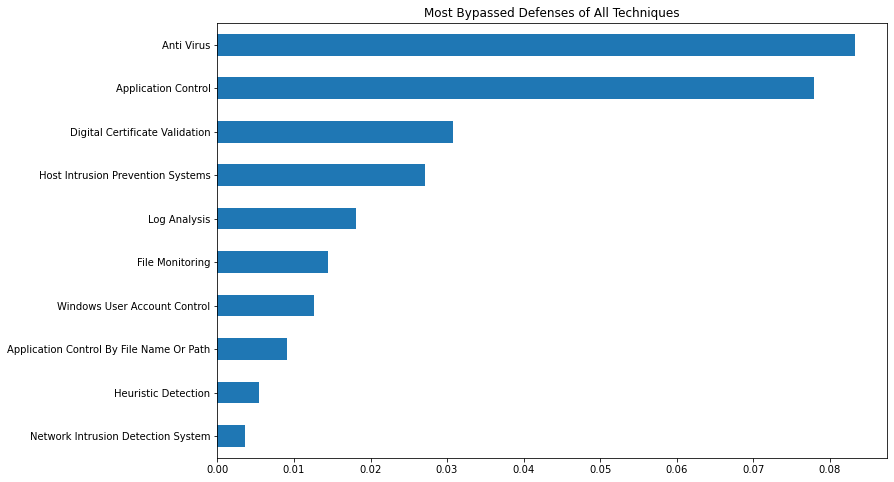

In [8]:
bypassed_stats = techniques[['Heuristic Detection', 'Anti Virus', 'Application Control By File Name Or Path', 'File Monitoring', 'Windows User Account Control', 'Application Control', 'Digital Certificate Validation', 'Host Intrusion Prevention Systems', 'Network Intrusion Detection System', 'Log Analysis', 'Encryption', 'User Mode Signature Validation', 'Autoruns Analysis', 'System Access Controls', 'Signature Based Detection', 'Firewall', 'Host Forensic Analysis', 'Binary Analysis', 'Router Acl', 'Static File Analysis', 'File System Access Controls', 'Unknown', 'Process Whitelisting', 'Defensive Network Service Scanning']].describe()

bypassed_stats = bypassed_stats.T
bypassed_stats.to_csv('most_bypassed_defenses.csv', index=False)

bypassed_stats['mean'][:10].sort_values().plot(kind = 'barh', figsize = (12,8), title = 'Most Bypassed Defenses of All Techniques');

In [9]:
techniques.drop(['contributors', 'url', 'version', 'platforms', 'tactics', 'Permissions_Required', 'Defenses_Bypassed', 'Supports_Remote'], axis =1, inplace=True)
techniques.columns

Index(['Technique_ID', 'Technique_Name', 'Technique_Description',
       'Technique_Created', 'Technique_Last_Modified', 'Technique_detection',
       'data sources', 'Sub_Technique', 'Parent_Technique', 'Technique_Age',
       'Execution', 'Privilege Escalation', 'Resource Development', 'Impact',
       'Discovery', 'Persistence', 'Defense Evasion', 'Reconnaissance',
       'Credential Access', 'Lateral Movement', 'Command And Control',
       'Exfiltration', 'Collection', 'Initial Access', 'Total_Tactics', 'PRE',
       'Google Workspace', 'Containers', 'Linux', 'IaaS', 'Office 365', 'SaaS',
       'macOS', 'Windows', 'Azure AD', 'Network', 'Total_Platforms', 'Unknown',
       'root', 'Administrator', 'SYSTEM', 'User', 'Total_Permissions',
       'System Access Controls', 'Signature Based Detection',
       'Application Control', 'Application Control By File Name Or Path',
       'Digital Certificate Validation', 'Autoruns Analysis',
       'Process Whitelisting', 'Firewall', 'File M

In [10]:
techniques.describe(include='all')

<ipython-input-10-f9a322229663>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

<ipython-input-10-f9a322229663>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,Technique_ID,Technique_Name,Technique_Description,Technique_Created,Technique_Last_Modified,Technique_detection,data sources,Sub_Technique,Parent_Technique,Technique_Age,...,Defensive Network Service Scanning,Binary Analysis,File System Access Controls,Host Forensic Analysis,Host Intrusion Prevention Systems,Network Intrusion Detection System,Router Acl,Anti Virus,Log Analysis,Total_Bypassed
count,552,552,552,552,552,552,472,552,367,552.000000,...,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000
unique,552,552,552,101,102,470,251,2,93,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,T1587.003,Office Application Startup: Outlook Forms,Adversaries may acquire credentials from the W...,2017-05-31 00:00:00,2021-04-15 00:00:00,Much of this activity may have a very high occ...,"Command: Command Execution, Process: Process C...",True,T1546,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,1,69,73,33,19,367,15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,2017-05-31 00:00:00,2020-01-24 00:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2021-04-23 00:00:00,2021-04-29 00:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,597.942029,...,0.001812,0.001812,0.012681,0.034420,0.027174,0.003623,0.001812,0.083333,0.018116,1.255435
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,395.048896,...,0.042563,0.042563,0.111996,0.182472,0.162737,0.060138,0.042563,0.276636,0.133492,0.822752
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,450.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [11]:
#Finding the most current Techniques actors use to exploit systems by looking at the last modified date
techniques = find_recent_techniques(techniques)
techniques['Technique_Updated'].describe()

count    552.000000
mean     234.126812
std      166.224102
min       44.000000
25%       59.000000
50%      233.000000
75%      440.000000
max      505.000000
Name: Technique_Updated, dtype: float64

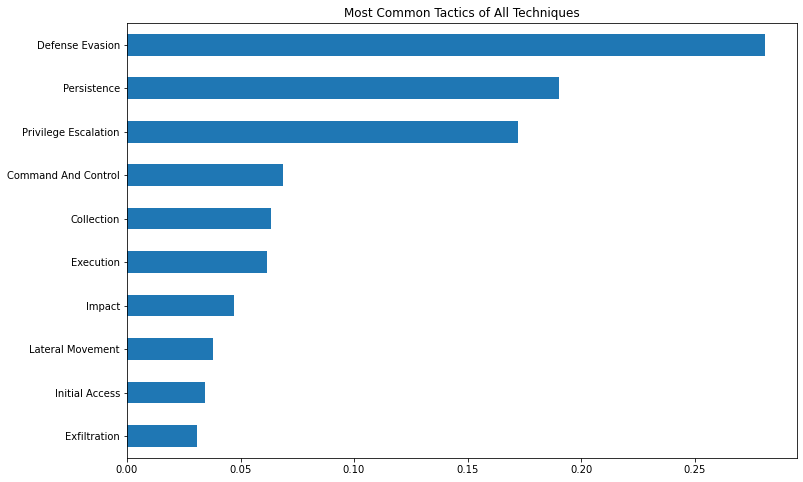

In [12]:
tactics_stats = pd.DataFrame(techniques[['Command And Control', 'Persistence', 'Privilege Escalation', 'Exfiltration', 'Impact', 'Execution', 'Lateral Movement', 'Initial Access', 'Defense Evasion', 'Collection', 'Discovery', 'Reconnaissance', 'Credential Access', 'Resource Development', 'Total_Tactics']]).describe(include='all')
tactics_stats = tactics_stats.T

tactics_stats['mean'][:10].sort_values().plot(kind = 'barh', figsize = (12,8), title = 'Most Common Tactics of All Techniques');
tactics_stats.to_csv('tactics_stats.csv', index=False)

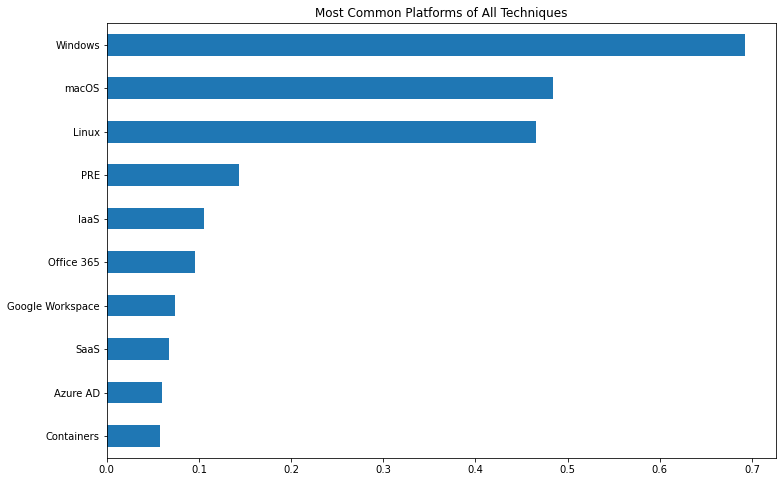

In [13]:
platforms_stats = pd.DataFrame(techniques[[ 'PRE', 'SaaS', 'Linux', 'Google Workspace', 'IaaS', 'Office 365', 'Containers', 'macOS', 'Windows', 'Azure AD', 'Network', 'Total_Platforms']]).describe(include='all')
platforms_stats = platforms_stats.T

platforms_stats['mean'][:10].sort_values().plot(kind = 'barh', figsize = (12,8), title = 'Most Common Platforms of All Techniques');
platforms_stats.to_csv('platforms_stats.csv', index=False)

# Merge Technique details with groups dataframe

In [14]:
techniques.columns

Index(['Technique_ID', 'Technique_Name', 'Technique_Description',
       'Technique_Created', 'Technique_Last_Modified', 'Technique_detection',
       'data sources', 'Sub_Technique', 'Parent_Technique', 'Technique_Age',
       'Execution', 'Privilege Escalation', 'Resource Development', 'Impact',
       'Discovery', 'Persistence', 'Defense Evasion', 'Reconnaissance',
       'Credential Access', 'Lateral Movement', 'Command And Control',
       'Exfiltration', 'Collection', 'Initial Access', 'Total_Tactics', 'PRE',
       'Google Workspace', 'Containers', 'Linux', 'IaaS', 'Office 365', 'SaaS',
       'macOS', 'Windows', 'Azure AD', 'Network', 'Total_Platforms', 'Unknown',
       'root', 'Administrator', 'SYSTEM', 'User', 'Total_Permissions',
       'System Access Controls', 'Signature Based Detection',
       'Application Control', 'Application Control By File Name Or Path',
       'Digital Certificate Validation', 'Autoruns Analysis',
       'Process Whitelisting', 'Firewall', 'File M

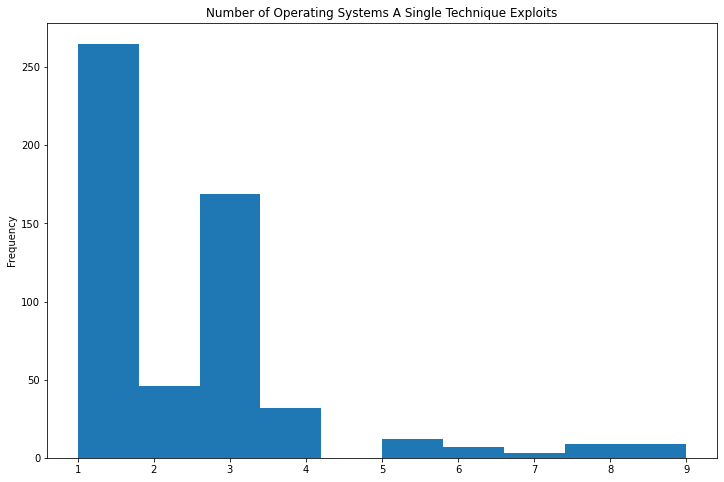

In [15]:
techniques['Total_Platforms'].plot(kind='hist', figsize=(12,8),title='Number of Operating Systems A Single Technique Exploits');

# Add Detail about Mitigations For Techniques

In [16]:
mitigations_df = pd.read_excel(path + 'enterprise-attack-v9.0.xlsx',sheet_name='mitigations', header=0, index_col=None)
mitigations_df.columns = ['Mitigation_ID','Mitigation_Type','Mitigation_Description','url','Mitigation_Created','Mitigation_Modified','version']


mitigations_df.to_csv('mitigations.csv', index=False)

mitigations_df.drop(['url', 'version'], axis=1, inplace=True)

In [17]:
techniques.columns

Index(['Technique_ID', 'Technique_Name', 'Technique_Description',
       'Technique_Created', 'Technique_Last_Modified', 'Technique_detection',
       'data sources', 'Sub_Technique', 'Parent_Technique', 'Technique_Age',
       'Execution', 'Privilege Escalation', 'Resource Development', 'Impact',
       'Discovery', 'Persistence', 'Defense Evasion', 'Reconnaissance',
       'Credential Access', 'Lateral Movement', 'Command And Control',
       'Exfiltration', 'Collection', 'Initial Access', 'Total_Tactics', 'PRE',
       'Google Workspace', 'Containers', 'Linux', 'IaaS', 'Office 365', 'SaaS',
       'macOS', 'Windows', 'Azure AD', 'Network', 'Total_Platforms', 'Unknown',
       'root', 'Administrator', 'SYSTEM', 'User', 'Total_Permissions',
       'System Access Controls', 'Signature Based Detection',
       'Application Control', 'Application Control By File Name Or Path',
       'Digital Certificate Validation', 'Autoruns Analysis',
       'Process Whitelisting', 'Firewall', 'File M

There are 628581 words in the Technique Description fields.


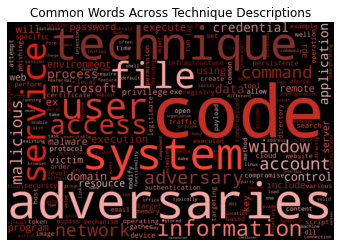

In [18]:
techniques['Technique_Description'] = techniques['Technique_Description'].astype('str')
text2 = " ".join(tech for tech in techniques['Technique_Description'])
text2 = text2.lower().strip()
print ("There are {} words in the Technique Description fields.".format(len(text2)))
stopwords = set(STOPWORDS)
stopwords.update(["primarily", "part", "may", "within", "via",  "use", "including", "used", "report", "written", "citation", "https", "attack", "mitre", "org", "software", "s0363", "s0154", "s0002", "t1059", "ncsc", ""])

wordcloud = WordCloud(stopwords=stopwords, background_color="black", width=1800, height=1200, collocations=False).generate(text2)
plt.imshow(wordcloud.recolor(color_func=random_redcolor_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.title('Common Words Across Technique Descriptions')
plt.show()

There are 332728 words in the Technique Detection fields.


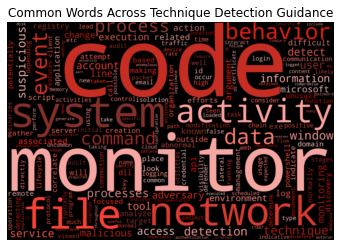

In [19]:
techniques['Technique_detection'] = techniques['Technique_detection'].astype('str')
text2 = " ".join(review for review in techniques['Technique_detection'])
text2 = text2.lower().strip()
print ("There are {} words in the Technique Detection fields.".format(len(text2)))
stopwords = set(STOPWORDS)
stopwords.update(["primarily", "part", "may", "within", "via",  "use", "including", "used", "report", "written", "citation", "https", "attack", "mitre", "org", "software", "s0363", "s0154", "s0002", "t1059", "ncsc", ""])

wordcloud = WordCloud(stopwords=stopwords, background_color="black", width=1800, height=1200, collocations=False).generate(text2)
plt.imshow(wordcloud.recolor(color_func=random_redcolor_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.title('Common Words Across Technique Detection Guidance')
plt.show()

In [20]:
techniques = parse_data_sources(techniques)

{'Network Traffic: Network Connection Creation', 'Volume: Volume Deletion', 'Firmware: Firmware Modification', 'Network Share: Network Share Access', 'Kernel: Kernel Module Load', 'Drive: Drive Creation', 'Process: Process Termination', 'Firewall: Firewall Metadata', 'Cloud Storage: Cloud Storage Deletion', 'Volume: Volume Modification', 'Snapshot: Snapshot Modification', 'Process: OS API Execution', 'Sensor Health: Host Status', 'Cloud Service: Cloud Service Metadata', 'Drive: Drive Access', 'Group: Group Modification', 'Cluster: Cluster Metadata', 'Instance: Instance Stop', 'Group: Group Enumeration', 'Process: Process Metadata', 'Pod: Pod Creation', 'Snapshot: Snapshot Creation', 'Pod: Pod Modification', 'Service: Service Metadata', 'Image: Image Deletion', 'Cloud Storage: Cloud Storage Modification', 'Active Directory: Active Directory Object Modification', 'Windows Registry: Windows Registry Key Access', 'Pod: Pod Enumeration', 'File: File Metadata', 'Instance: Instance Creation',

In [21]:
technique_mitigation = pd.read_excel(path + 'enterprise-attack-v9.0.xlsx',sheet_name='relationships', header=0, index_col=None)
technique_mitigation = technique_mitigation[technique_mitigation['source type'] == 'mitigation']
technique_mitigation.rename(columns = {'source ID': 'Mitigation_ID', 'target ID':'Technique_ID'}, inplace=True)
technique_mitigation = technique_mitigation[['Mitigation_ID', 'Technique_ID']]
techniques = techniques.merge(technique_mitigation, on='Technique_ID', how='outer')
techniques = techniques.merge(mitigations_df, on='Mitigation_ID', how = 'outer')
techniques

,Technique_ID,Technique_Name,Technique_Description,Technique_Created,Technique_Last_Modified,Technique_detection,data sources,Sub_Technique,Parent_Technique,Technique_Age,...,Instance: Instance Start,Image: Image Creation,Cloud Storage: Cloud Storage Creation,Container: Container Enumeration,Total_Data_Sources,Mitigation_ID,Mitigation_Type,Mitigation_Description,Mitigation_Created,Mitigation_Modified
0,T1548,Abuse Elevation Control Mechanism,Adversaries may circumvent mechanisms designed...,2020-01-30,2020-07-22,Monitor the file system for files that have th...,"Command: Command Execution,File: File Metadata...",False,NaN,499,...,0,0,0,0,7,M1047,Audit,"Perform audits or scans of systems, permission...",11 June 2019,19 November 2020
1,T1548.002,Abuse Elevation Control Mechanism: Bypass User...,Adversaries may bypass UAC mechanisms to eleva...,2020-01-30,2020-07-22,There are many ways to perform UAC bypasses wh...,"Command: Command Execution,Process: Process Cr...",True,T1548,499,...,0,0,0,0,4,M1047,Audit,"Perform audits or scans of systems, permission...",11 June 2019,19 November 2020
2,T1087.004,Account Discovery: Cloud Account,Adversaries may attempt to get a listing of cl...,2020-02-21,2021-03-16,"Monitor processes, command-line arguments, and...","Command: Command Execution,User Account: User ...",True,T1087,477,...,0,0,0,0,2,M1047,Audit,"Perform audits or scans of systems, permission...",11 June 2019,19 November 2020
3,T1560,Archive Collected Data,An adversary may compress and/or encrypt data ...,2020-02-20,2020-10-21,Archival software and archived files can be de...,"Command: Command Execution,File: File Creation...",False,NaN,478,...,0,0,0,0,4,M1047,Audit,"Perform audits or scans of systems, permission...",11 June 2019,19 November 2020
4,T1560.001,Archive Collected Data: Archive via Utility,An adversary may compress or encrypt data that...,2020-02-20,2020-03-25,Common utilities that may be present on the sy...,"Command: Command Execution,File: File Creation...",True,T1560,478,...,0,0,0,0,3,M1047,Audit,"Perform audits or scans of systems, permission...",11 June 2019,19 November 2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,T1055.012,Process Injection: Process Hollowing,Adversaries may inject malicious code into sus...,2020-01-14,2020-11-10,Monitoring Windows API calls indicative of the...,"Process: OS API Execution,Process: Process Access",True,T1055,515,...,0,0,0,0,2,M1040,Behavior Prevention on Endpoint,Use capabilities to prevent suspicious behavio...,11 June 2019,11 June 2019
1109,T1055.008,Process Injection: Ptrace System Calls,Adversaries may inject malicious code into pro...,2020-01-14,2020-06-20,Monitoring for Linux specific calls such as th...,"Process: OS API Execution,Process: Process Access",True,T1055,515,...,0,0,0,0,2,M1040,Behavior Prevention on Endpoint,Use capabilities to prevent suspicious behavio...,11 June 2019,11 June 2019
1110,T1055.003,Process Injection: Thread Execution Hijacking,Adversaries may inject malicious code into hij...,2020-01-14,2020-11-10,Monitoring Windows API calls indicative of the...,"Process: OS API Execution,Process: Process Access",True,T1055,515,...,0,0,0,0,2,M1040,Behavior Prevention on Endpoint,Use capabilities to prevent suspicious behavio...,11 June 2019,11 June 2019
1111,T1055.005,Process Injection: Thread Local Storage,Adversaries may inject malicious code into pro...,2020-01-14,2020-11-10,Monitoring Windows API calls indicative of the...,"Process: OS API Execution,Process: Process Access",True,T1055,515,...,0,0,0,0,2,M1040,Behavior Prevention on Endpoint,Use capabilities to prevent suspicious behavio...,11 June 2019,11 June 2019


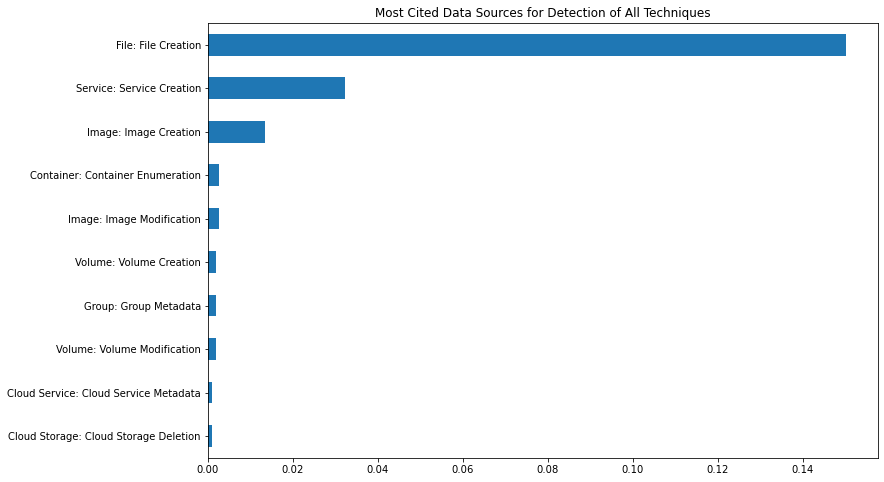

In [22]:
data_sources_stats = pd.DataFrame(techniques[['Volume: Volume Modification', 'Cloud Storage: Cloud Storage Deletion', 'Group: Group Metadata', 'File: File Creation', 'Service: Service Creation', 'Image: Image Modification', 'Image: Image Creation', 'Container: Container Enumeration', 'Cloud Service: Cloud Service Metadata', 'Volume: Volume Creation', 'Drive: Drive Modification', 'Sensor Health: Host Status', 'Process: Process Creation', 'Group: Group Modification', 'Cloud Service: Cloud Service Disable', 'Scheduled Job: Scheduled Job Creation', 'Snapshot: Snapshot Enumeration', 'User Account: User Account Deletion', 'Group: Group Enumeration', 'Logon Session: Logon Session Creation', 'Firewall: Firewall Metadata', 'Firmware: Firmware Modification', 'Firewall: Firewall Disable', 'Kernel: Kernel Module Load', 'Web Credential: Web Credential Usage', 'Driver: Driver Metadata', 'Active Directory: Active Directory Object Modification', 'User Account: User Account Creation', 'Network Traffic: Network Traffic Content', 'File: File Deletion', 'Active Directory: Active Directory Credential Request', 'Cloud Service: Cloud Service Modification', 'Snapshot: Snapshot Deletion', 'Instance: Instance Stop', 'Service: Service Modification', 'Network Traffic: Network Connection Creation', 'Application Log: Application Log Content', 'Process: OS API Execution', 'Script: Script Execution', 'Cloud Storage: Cloud Storage Metadata', 'Firewall: Firewall Rule Modification', 'User Account: User Account Modification', 'Pod: Pod Modification', 'File: File Modification', 'Instance: Instance Modification', 'Web Credential: Web Credential Creation', 'Cloud Storage: Cloud Storage Modification', 'Pod: Pod Metadata', 'Container: Container Start', 'Image: Image Metadata', 'Command: Command Execution', 'Cluster: Cluster Metadata', 'Snapshot: Snapshot Creation', 'Pod: Pod Enumeration', 'Instance: Instance Enumeration', 'Cloud Storage: Cloud Storage Enumeration', 'Windows Registry: Windows Registry Key Deletion', 'Instance: Instance Creation', 'Active Directory: Active Directory Object Access', 'Cloud Storage: Cloud Storage Access', 'nan', 'File: File Content', 'Pod: Pod Creation', 'Volume: Volume Metadata', 'Snapshot: Snapshot Modification', 'File: File Access', 'Network Traffic: Network Traffic Flow', 'Volume: Volume Deletion', 'Active Directory: Active Directory Object Deletion', 'Driver: Driver Load', 'Container: Container Creation', 'Process: Process Metadata', 'Process: Process Termination', 'User Account: User Account Authentication', 'Scheduled Job: Scheduled Job Modification', 'Logon Session: Logon Session Metadata', 'Network Share: Network Share Access', 'Volume: Volume Enumeration', 'Instance: Instance Metadata', 'Service: Service Metadata', 'Active Directory: Active Directory Object Creation', 'Windows Registry: Windows Registry Key Creation', 'Module: Module Load', 'Drive: Drive Access', 'Process: Process Access', 'File: File Metadata', 'Firewall: Firewall Enumeration', 'Image: Image Deletion', 'Snapshot: Snapshot Metadata', 'Cloud Service: Cloud Service Enumeration', 'Scheduled Job: Scheduled Job Metadata', 'Windows Registry: Windows Registry Key Modification', 'Windows Registry: Windows Registry Key Access', 'User Account: User Account Metadata', 'Cloud Storage: Cloud Storage Creation', 'Instance: Instance Start', 'Instance: Instance Deletion', 'Drive: Drive Creation', 'WMI: WMI Creation', 'Container: Container Metadata']].describe(include='all'))
data_sources_stats = data_sources_stats.T
data_sources_stats['mean'][:10].sort_values().plot(kind = 'barh', figsize = (12,8), title = 'Most Cited Data Sources for Detection of All Techniques');

data_sources_stats.to_csv('data_sources_stats.csv', index=False)

There are 133241 words in the mitigation descriptions.


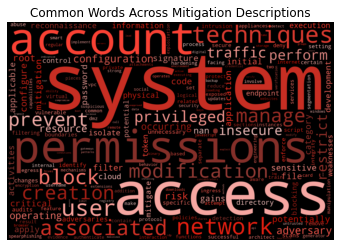

In [23]:
techniques['Mitigation_Description'] = techniques['Mitigation_Description'].astype('str')
text2 = " ".join(mitigate for mitigate in techniques['Mitigation_Description'])
text2 = text2.lower().strip()
print ("There are {} words in the mitigation descriptions.".format(len(text2)))
stopwords = set(STOPWORDS)
stopwords.update(["primarily","include", 'etc', "part", "may", "within", "via",  "use", "including", "used", "report", "written", "citation", "https", "attack", "mitre", "org", "software", "s0363", "s0154", "s0002", "t1059", "ncsc", ""])

wordcloud = WordCloud(stopwords=stopwords, background_color="black", width=1800, height=1200, collocations=False).generate(text2)
plt.imshow(wordcloud.recolor(color_func=random_redcolor_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.title('Common Words Across Mitigation Descriptions')
plt.show()

There are 109889 words in the data sources.


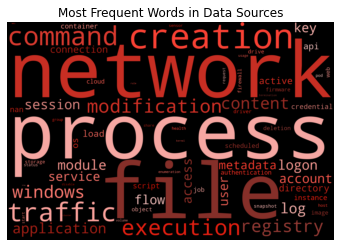

In [24]:
techniques['data sources'] = techniques['data sources'].astype('str')
text2 = " ".join(mitigate for mitigate in techniques['data sources'])
text2 = text2.lower().strip()
print ("There are {} words in the data sources.".format(len(text2)))
stopwords = set(STOPWORDS)
stopwords.update(["primarily","include", 'etc', "part", "may", "within", "via",  "use", "including", "used", "report", "written", "citation", "https", "attack", "mitre", "org",  ""])

wordcloud = WordCloud(stopwords=stopwords, background_color="black", width=1800, height=1200, collocations=False).generate(text2)
plt.imshow(wordcloud.recolor(color_func=random_redcolor_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.title('Most Frequent Words in Data Sources')
plt.show()

In [25]:
group_technique = pd.read_excel(path + 'enterprise-attack-v9.0.xlsx',sheet_name='relationships', header=0, index_col=None)
group_technique = group_technique[group_technique['source type'] == 'group']
group_technique = group_technique[group_technique['target type'] == 'technique']
group_technique.rename(columns = {'source ID': 'Group_ID', 'target ID':'Technique_ID'}, inplace=True)
group_technique = group_technique[['Group_ID', 'Technique_ID']]
group_technique

techniques = techniques.merge(group_technique, on='Technique_ID', how='outer')

techniques

,Technique_ID,Technique_Name,Technique_Description,Technique_Created,Technique_Last_Modified,Technique_detection,data sources,Sub_Technique,Parent_Technique,Technique_Age,...,Image: Image Creation,Cloud Storage: Cloud Storage Creation,Container: Container Enumeration,Total_Data_Sources,Mitigation_ID,Mitigation_Type,Mitigation_Description,Mitigation_Created,Mitigation_Modified,Group_ID
0,T1548,Abuse Elevation Control Mechanism,Adversaries may circumvent mechanisms designed...,2020-01-30,2020-07-22,Monitor the file system for files that have th...,"Command: Command Execution,File: File Metadata...",False,NaN,499,...,0,0,0,7,M1047,Audit,"Perform audits or scans of systems, permission...",11 June 2019,19 November 2020,NaN
1,T1548,Abuse Elevation Control Mechanism,Adversaries may circumvent mechanisms designed...,2020-01-30,2020-07-22,Monitor the file system for files that have th...,"Command: Command Execution,File: File Metadata...",False,NaN,499,...,0,0,0,7,M1038,Execution Prevention,Block execution of code on a system through ap...,11 June 2019,20 June 2020,NaN
2,T1548,Abuse Elevation Control Mechanism,Adversaries may circumvent mechanisms designed...,2020-01-30,2020-07-22,Monitor the file system for files that have th...,"Command: Command Execution,File: File Metadata...",False,NaN,499,...,0,0,0,7,M1028,Operating System Configuration,Make configuration changes related to the oper...,06 June 2019,19 June 2020,NaN
3,T1548,Abuse Elevation Control Mechanism,Adversaries may circumvent mechanisms designed...,2020-01-30,2020-07-22,Monitor the file system for files that have th...,"Command: Command Execution,File: File Metadata...",False,NaN,499,...,0,0,0,7,M1026,Privileged Account Management,"Manage the creation, modification, use, and pe...",06 June 2019,31 March 2020,NaN
4,T1548,Abuse Elevation Control Mechanism,Adversaries may circumvent mechanisms designed...,2020-01-30,2020-07-22,Monitor the file system for files that have th...,"Command: Command Execution,File: File Metadata...",False,NaN,499,...,0,0,0,7,M1022,Restrict File and Directory Permissions,Restrict access by setting directory and file ...,06 June 2019,20 May 2020,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5547,T1055.012,Process Injection: Process Hollowing,Adversaries may inject malicious code into sus...,2020-01-14,2020-11-10,Monitoring Windows API calls indicative of the...,"Process: OS API Execution,Process: Process Access",True,T1055,515,...,0,0,0,2,M1040,Behavior Prevention on Endpoint,Use capabilities to prevent suspicious behavio...,11 June 2019,11 June 2019,G0027
5548,T1055.012,Process Injection: Process Hollowing,Adversaries may inject malicious code into sus...,2020-01-14,2020-11-10,Monitoring Windows API calls indicative of the...,"Process: OS API Execution,Process: Process Access",True,T1055,515,...,0,0,0,2,M1040,Behavior Prevention on Endpoint,Use capabilities to prevent suspicious behavio...,11 June 2019,11 June 2019,G0045
5549,T1055.003,Process Injection: Thread Execution Hijacking,Adversaries may inject malicious code into hij...,2020-01-14,2020-11-10,Monitoring Windows API calls indicative of the...,"Process: OS API Execution,Process: Process Access",True,T1055,515,...,0,0,0,2,M1040,Behavior Prevention on Endpoint,Use capabilities to prevent suspicious behavio...,11 June 2019,11 June 2019,NaN
5550,T1055.005,Process Injection: Thread Local Storage,Adversaries may inject malicious code into pro...,2020-01-14,2020-11-10,Monitoring Windows API calls indicative of the...,"Process: OS API Execution,Process: Process Access",True,T1055,515,...,0,0,0,2,M1040,Behavior Prevention on Endpoint,Use capabilities to prevent suspicious behavio...,11 June 2019,11 June 2019,NaN


In [27]:
techniques.Mitigation_Type.value_counts()

Privileged Account Management              444
Network Intrusion Prevention               402
Execution Prevention                       341
User Training                              300
Disable or Remove Feature or Program       262
Antivirus/Antimalware                      260
Restrict Web-Based Content                 252
User Account Management                    228
Password Policies                          211
Audit                                      200
Operating System Configuration             183
Restrict File and Directory Permissions    143
Network Segmentation                       139
Pre-compromise                             130
Software Configuration                     127
Multi-factor Authentication                124
Code Signing                               120
Update Software                            116
Filter Network Traffic                     109
Exploit Protection                         109
Application Isolation and Sandboxing        96
Encrypt Sensi

In [28]:
techniques.Technique_ID.describe()

count          5552
unique          552
top       T1566.001
freq            285
Name: Technique_ID, dtype: object

In [29]:
software_technique = pd.read_excel(path + 'enterprise-attack-v9.0.xlsx',sheet_name='relationships', header=0, index_col=None)
software_technique = software_technique[software_technique['source type'] == 'software']
software_technique = software_technique[software_technique['target type'] == 'technique']
software_technique.rename(columns = {'source ID': 'Software_ID', 'target ID':'Technique_ID'}, inplace=True)
software_technique = software_technique[['Software_ID', 'Technique_ID']]
software_technique

,Software_ID,Technique_ID
4070,S0066,T1083
4071,S0066,T1573.001
4072,S0066,T1070.006
4073,S0066,T1071.001
4074,S0065,T1083
...,...,...
9779,S0350,T1082
9780,S0350,T1016
9781,S0350,T1033
9782,S0350,T1059.003


In [30]:
group_software = pd.read_excel(path + 'enterprise-attack-v9.0.xlsx',sheet_name='relationships', header=0, index_col=None)
group_software = group_software[group_software['source type'] == 'group']
group_software = group_software[group_software['target type'] == 'software']
group_software.rename(columns = {'source ID': 'Group_ID', 'target ID':'Software_ID', 'mapping description':'Software_Description'}, inplace=True)
group_software = group_software[['Software_ID', 'Group_ID', 'Software_Description']]
group_software

,Software_ID,Group_ID,Software_Description
1026,S0434,G0099,(Citation: QiAnXin APT-C-36 Feb2019)
1027,S0017,G0006,(Citation: Mandiant APT1)
1028,S0025,G0006,(Citation: Mandiant APT1)
1029,S0119,G0006,(Citation: Mandiant APT1)
1030,S0026,G0006,(Citation: Mandiant APT1)
...,...,...,...
1675,S0275,G0045,(Citation: FireEye APT10 Sept 2018)
1676,S0160,G0045,(Citation: Accenture Hogfish April 2018)(Citat...
1677,S0106,G0045,(Citation: PWC Cloud Hopper Technical Annex Ap...
1678,S0404,G0045,(Citation: FireEye APT10 Sept 2018)


In [31]:
software_technique = software_technique.merge(group_software, on='Software_ID', how='outer')

software_technique

,Software_ID,Technique_ID,Group_ID,Software_Description
0,S0066,T1083,G0024,(Citation: CrowdStrike Putter Panda)
1,S0066,T1573.001,G0024,(Citation: CrowdStrike Putter Panda)
2,S0066,T1070.006,G0024,(Citation: CrowdStrike Putter Panda)
3,S0066,T1071.001,G0024,(Citation: CrowdStrike Putter Panda)
4,S0065,T1083,G0024,(Citation: CrowdStrike Putter Panda)
...,...,...,...,...
9724,S0350,T1082,G0014,(Citation: McAfee Night Dragon)
9725,S0350,T1016,G0014,(Citation: McAfee Night Dragon)
9726,S0350,T1033,G0014,(Citation: McAfee Night Dragon)
9727,S0350,T1059.003,G0014,(Citation: McAfee Night Dragon)


In [32]:
techniques = techniques.merge(software_technique, on =['Group_ID', 'Technique_ID'], how= 'outer')

In [37]:
techniques.Software_ID.value_counts()

S0363    952
S0154    905
S0002    737
S0039    400
S0194    237
        ... 
S0224      1
S0123      1
S0101      1
S0041      1
S0120      1
Name: Software_ID, Length: 493, dtype: int64

In [42]:
software = pd.read_excel(path + 'enterprise-attack-v9.0.xlsx',sheet_name='software', header=0, index_col=None)
software.columns = ['Software_ID', 'Software_Name','Software_Description', 'url','Software_Created', 'Software_Modified', 'version','Software_Platforms', 'aliases','Software_Type','contributors']
software.drop(['Software_Description','url', 'version','aliases','contributors'], axis=1, inplace=True)
software

techniques = techniques.merge(software, on = 'Software_ID', how='outer')
techniques

In [44]:
techniques.describe(include='all')

<ipython-input-44-f9a322229663>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

<ipython-input-44-f9a322229663>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,Technique_ID,Technique_Name,Technique_Created,Technique_Last_Modified,Sub_Technique,Parent_Technique,Technique_Age,Execution,Privilege Escalation,Resource Development,...,Mitigation_Created,Mitigation_Modified,Group_ID,Software_ID,Software_Description,Software_Name,Software_Created,Software_Modified,Software_Platforms,Software_Type
count,14844,7682,7682,7682,7682,4912,7682.000000,7682.000000,7682.000000,7682.000000,...,6513,6513,12737,11443,9638,11443,11443,11443,11404,11443
unique,552,552,101,102,2,93,NaN,NaN,NaN,NaN,...,6,19,120,493,371,493,138,117,14,2
top,T1059.001,Command and Scripting Interpreter: PowerShell,2017-05-31 00:00:00,2020-03-26 00:00:00,True,T1059,NaN,NaN,NaN,NaN,...,06 June 2019,31 March 2020,G0096,S0363,(Citation: FireEye APT41 Aug 2019),Empire,31 May 2017,30 March 2020,Windows,malware
freq,403,384,1887,413,4912,798,NaN,NaN,NaN,NaN,...,2637,1715,521,952,266,952,3360,1797,8920,7871
first,NaN,NaN,2017-05-31 00:00:00,2020-01-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2021-04-23 00:00:00,2021-04-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,764.219995,0.215309,0.128222,0.010674,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,445.823158,0.411063,0.334358,0.102770,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,460.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
techniques_tableau = replace_commas(techniques)
techniques_tableau.columns
#techniques_tableau.drop(['Technique_Description', 'Mitigation_Description', 'Technique_detection', 'data sources'], axis = 1, inplace=True)

Index(['Technique_ID', 'Technique_Name', 'Technique_Created',
       'Technique_Last_Modified', 'Sub_Technique', 'Parent_Technique',
       'Technique_Age', 'Execution', 'Privilege Escalation',
       'Resource Development',
       ...
       'Mitigation_Created', 'Mitigation_Modified', 'Group_ID', 'Software_ID',
       'Software_Description', 'Software_Name', 'Software_Created',
       'Software_Modified', 'Software_Platforms', 'Software_Type'],
      dtype='object', length=178)

In [51]:
print(techniques_tableau.columns)
techniques.to_csv('techniques_tableau.csv', index=False)

Index(['Technique_ID', 'Technique_Name', 'Technique_Created',
       'Technique_Last_Modified', 'Sub_Technique', 'Parent_Technique',
       'Technique_Age', 'Execution', 'Privilege Escalation',
       'Resource Development',
       ...
       'Mitigation_Created', 'Mitigation_Modified', 'Group_ID', 'Software_ID',
       'Software_Description', 'Software_Name', 'Software_Created',
       'Software_Modified', 'Software_Platforms', 'Software_Type'],
      dtype='object', length=178)
